In [8]:
import pandas as pd
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.layers.merge import Concatenate
import matplotlib.gridspec as gridspec
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout, Bidirectional
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, BayesianRidge

In [9]:
df=pd.read_csv('IceCreamData.csv')
df['Fahrenheit']=df['Temperature'].apply(lambda row: row * 9/5+32)
df['Condition']=df['Fahrenheit'].apply(lambda row: 1 if row > 93 else 2 if (row >=80) & (row<=93) else 3 if (row>=68) & (row<80) else 4 if (row<68) else -99)

print(df.columns)


Index(['Temperature', 'Revenue', 'Fahrenheit', 'Condition'], dtype='object')


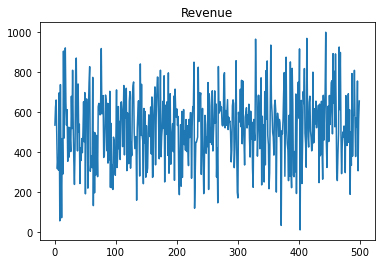

In [11]:
df["Revenue"].plot()
plt.title("Revenue")
plt.show()

C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


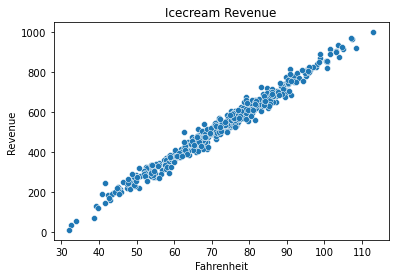

<AxesSubplot:xlabel='Fahrenheit', ylabel='Revenue'>

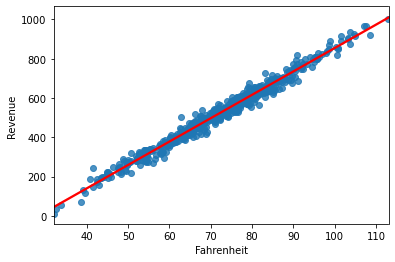

In [3]:
sns.scatterplot('Fahrenheit','Revenue',data=df)
plt.title('Icecream Revenue')
plt.show()

#df['Revenue'].plot()
sns.regplot(x='Fahrenheit',y='Revenue',data=df,line_kws={"color": "red"})

In [4]:
def create_dataset(dataset, look_back=3):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [5]:
look_back=5
dataset=df['Revenue']

scaler = MinMaxScaler(feature_range=(0, 1))

dataset = scaler.fit_transform(np.array(dataset).reshape(-1,1))

train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
#print(len(train), len(test))

#print(train)

trainX, y_train = create_dataset(train, look_back)
testX, y_test = create_dataset(test, look_back)

X_train = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
X_test = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Instructions for updating:
Colocations handled automatically by placer.


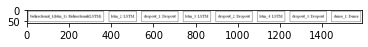

In [6]:
n_future = 1
features=2
timeSteps=5

model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True, 
                             input_shape=(X_train.shape[1], 1))))

model.add(LSTM(units= 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units= 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units= 50))
model.add(Dropout(0.2))
model.add(Dense(units = n_future))

model.compile(optimizer="adam", loss="mean_squared_error", metrics=["acc"])

plot_model(model, to_file='model.png')
img=plt.imread('model.png')
plt.imshow(img)
plt.show()

In [7]:
model.fit(X_train, y_train,epochs=50 , verbose=0 )

Instructions for updating:
Use tf.cast instead.


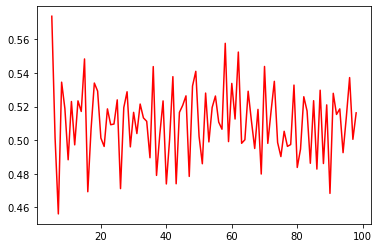

In [20]:
prediction = model.predict(X_test)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(prediction)+look_back, :] = prediction
# shift test predictions for plotting
#plt.plot(scaler.inverse_transform(dataset))
#plt.plot(trainPredictPlot, color='red')
plt.plot(trainPredictPlot,color='red')
#plt.legend(['Actual','Train','Test'])
plt.show()

In [75]:
X=df[['Fahrenheit','Condition']]
y=df['Revenue']
bayesian = BayesianRidge(fit_intercept=False, normalize=True)
bayesian.fit(X, y)

BayesianRidge(fit_intercept=False, normalize=True)

C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


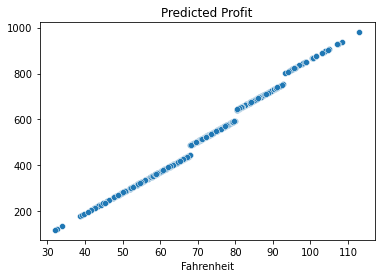

In [79]:
bayesian_pred = bayesian.predict(X)
sns.scatterplot(X['Fahrenheit'],bayesian_pred)
plt.title('Predicted Profit')
plt.show()



C:\Users\dnishimoto.BOISE\AppData\Local\Continuum\anaconda3\envs\deeplearning\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


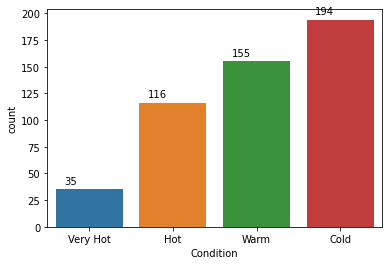

In [52]:
ax=sns.countplot('Condition',data=X)
x=np.arange(4)
plt.xticks(x,['Very Hot','Hot','Warm','Cold'])

for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+5))
        
plt.show()

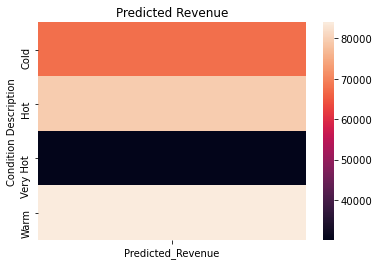

In [63]:
result_df=pd.DataFrame(X)
result_df["Predicted_Revenue"]=bayesian_pred 
result_df["Revenue"]=y
result_df["Condition Description"]=result_df["Condition"].apply(lambda row: 'Very Hot' if (row==1) else 'Hot' if (row==2) else 'Warm' if (row==3) else 'Cold' if (row==4) else 'Unknown')
#bayesian_pred 
#print(result_df)
fp=result_df.pivot_table(index='Condition Description', values='Predicted_Revenue',aggfunc='sum')
sns.heatmap(fp)
plt.title("Predicted Revenue")
plt.show()

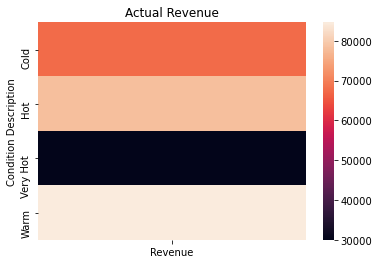

In [64]:
fp=result_df.pivot_table(index='Condition Description', values='Revenue',aggfunc='sum')
sns.heatmap(fp)
plt.title('Actual Revenue')
plt.show()